# Experiments with custom models and datasets

In [40]:
# import our utils
from utils import datasets, metrics, core_models, cpd_models, klcpd, tscp
from utils.model_utils import fix_seeds

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import pytorch_lightning as pl

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

%load_ext autoreload
%autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fix seeds

In [9]:
SEED = 42
fix_seeds(SEED)

## Create dataset

You should define your own CustomDataset class with self.data and self.labels and then use our CPDDatasets wrapper. For example, we take our SyntheticNormalDataset (100D) defined in utils/datasets.py.

In [10]:
experiments_name = "synthetic_100D"
train_dataset, test_dataset = datasets.CPDDatasets(experiments_name=experiments_name).get_dataset_()

## Create custom core model

You should use torch.nn.Module wrapper for your core model and define self.forward method. For example, we take our BaseRnn model defined in utils/core_models.py. We use default parameters (specified in configs/synthetic_100D_seq2seq.yaml file).

In [11]:
# define core model for an experiment with our 'indid' loss
core_model_indid = core_models.BaseRnn(
    input_size=100,
    hidden_dim=8,
    n_layers=1,
    drop_prob=0.5
)

/home/eromanenkova/stash/eromanenkova/miniconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [14]:
# create dictionary with default arguments for consistency with our interface
# define arguments as they are set in the corresponding config file
learning = dict()
learning["batch_size"] = 64
learning["lr"] = 0.001
learning["grad_clip"] = 0.0

loss = dict()
loss["T"] = 32

args = dict()
args["learning"] = learning
args["loss"] = loss

args["experiments_name"] = experiments_name
args["num_workers"] = 2

In [15]:
# define CPDModel with our 'indid' loss
indid_model = cpd_models.CPDModel(
    loss_type="indid",
    args=args,
    model=core_model_indid,
    train_dataset=train_dataset,
    test_dataset=test_dataset
)

## Train the model using pytorch_lightning trainer

In [17]:
# use logger
model_name = f'seq2seq_indid_seed_{SEED}'
logger = TensorBoardLogger(save_dir=f'logs/{experiments_name}', name=model_name)

# define trainer with custom parameters
trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    benchmark=True,
    check_val_every_n_epoch=1,
    gradient_clip_val=0.,
    logger=logger,
    
    # use early stopping
    callbacks=EarlyStopping(monitor="val_loss", min_delta=0, patience=10)
)

trainer.fit(indid_model)

/home/eromanenkova/stash/eromanenkova/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 3.5 K 
1 | loss  | CPDLoss | 0     
----------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


## Evaluate your model

In [18]:
# create list of thresholds from [0, 1]
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

metrics_local, delay_list, fp_delay_list = \
    metrics.evaluation_pipeline(indid_model,
                                indid_model.val_dataloader(),
                                threshold_list,
                                device="cuda", # choose 'cpu' or 'cuda' if available
                                model_type="seq2seq",
                                verbose=True
                               )

  1%|▊                                                                             | 1/102 [00:01<01:45,  1.05s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


  2%|█▌                                                                            | 2/102 [00:01<01:27,  1.15it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


  3%|██▎                                                                           | 3/102 [00:02<01:18,  1.26it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


  4%|███                                                                           | 4/102 [00:03<01:17,  1.26it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


  5%|███▊                                                                          | 5/102 [00:04<01:15,  1.28it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


  6%|████▌                                                                         | 6/102 [00:04<01:10,  1.36it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


  7%|█████▎                                                                        | 7/102 [00:05<01:09,  1.37it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


  8%|██████                                                                        | 8/102 [00:06<01:08,  1.37it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


  9%|██████▉                                                                       | 9/102 [00:06<01:05,  1.42it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 10%|███████▌                                                                     | 10/102 [00:07<01:07,  1.37it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 11%|████████▎                                                                    | 11/102 [00:08<01:06,  1.37it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 12%|█████████                                                                    | 12/102 [00:09<01:06,  1.35it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 13%|█████████▊                                                                   | 13/102 [00:09<01:06,  1.33it/s]

TN: 1, FP: 298, FN: 0, TP: 1, DELAY:0.0, FP_DELAY:0.7733333110809326, COVER: 0.8236637369791666


 14%|██████████▌                                                                  | 14/102 [00:10<01:07,  1.31it/s]

TN: 1, FP: 298, FN: 0, TP: 1, DELAY:0.0, FP_DELAY:0.7733333110809326, COVER: 0.8236637369791666


 15%|███████████▎                                                                 | 15/102 [00:11<01:07,  1.29it/s]

TN: 1, FP: 297, FN: 0, TP: 2, DELAY:0.0, FP_DELAY:0.9566666483879089, COVER: 0.8252974446614584


 16%|████████████                                                                 | 16/102 [00:12<01:05,  1.32it/s]

TN: 3, FP: 292, FN: 0, TP: 5, DELAY:0.0, FP_DELAY:2.4166667461395264, COVER: 0.8292826334635417


 17%|████████████▊                                                                | 17/102 [00:12<01:03,  1.34it/s]

TN: 7, FP: 287, FN: 0, TP: 6, DELAY:0.0, FP_DELAY:4.163333415985107, COVER: 0.8298490397135416


 18%|█████████████▌                                                               | 18/102 [00:13<01:04,  1.30it/s]

TN: 11, FP: 278, FN: 0, TP: 11, DELAY:0.0033333334140479565, FP_DELAY:6.853333473205566, COVER: 0.8345673101233818


 19%|██████████████▎                                                              | 19/102 [00:14<01:01,  1.34it/s]

TN: 20, FP: 257, FN: 0, TP: 23, DELAY:0.0033333334140479565, FP_DELAY:12.876667022705078, COVER: 0.8460317469723402


 20%|███████████████                                                              | 20/102 [00:15<01:00,  1.36it/s]

TN: 29, FP: 246, FN: 0, TP: 25, DELAY:0.0033333334140479565, FP_DELAY:17.0766658782959, COVER: 0.8477081792640069


 21%|███████████████▊                                                             | 21/102 [00:15<00:57,  1.40it/s]

TN: 40, FP: 227, FN: 0, TP: 33, DELAY:0.0033333334140479565, FP_DELAY:23.486665725708008, COVER: 0.8553078700192153


 22%|████████████████▌                                                            | 22/102 [00:16<00:57,  1.40it/s]

TN: 59, FP: 201, FN: 0, TP: 40, DELAY:0.0033333334140479565, FP_DELAY:33.573333740234375, COVER: 0.863942310123382


 23%|█████████████████▎                                                           | 23/102 [00:17<00:55,  1.43it/s]

TN: 72, FP: 179, FN: 0, TP: 49, DELAY:0.006666666828095913, FP_DELAY:41.04999923706055, COVER: 0.8718528082431891


 24%|██████████████████                                                           | 24/102 [00:17<00:56,  1.37it/s]

TN: 82, FP: 151, FN: 0, TP: 67, DELAY:0.006666666828095913, FP_DELAY:48.46666717529297, COVER: 0.8901523687900641


 25%|██████████████████▊                                                          | 25/102 [00:18<00:56,  1.37it/s]

TN: 91, FP: 129, FN: 1, TP: 79, DELAY:0.07000000029802322, FP_DELAY:55.25666809082031, COVER: 0.9040235198076181


 25%|███████████████████▋                                                         | 26/102 [00:19<00:56,  1.34it/s]

TN: 98, FP: 113, FN: 1, TP: 88, DELAY:0.07333333045244217, FP_DELAY:59.836666107177734, COVER: 0.9153364853781123


 26%|████████████████████▍                                                        | 27/102 [00:20<00:56,  1.32it/s]

TN: 102, FP: 97, FN: 2, TP: 99, DELAY:0.14000000059604645, FP_DELAY:64.33333587646484, COVER: 0.9284230466188743


 27%|█████████████████████▏                                                       | 28/102 [00:21<00:56,  1.31it/s]

TN: 110, FP: 75, FN: 2, TP: 113, DELAY:0.14000000059604645, FP_DELAY:70.65666961669922, COVER: 0.946130973051166


 28%|█████████████████████▉                                                       | 29/102 [00:21<00:56,  1.30it/s]

TN: 115, FP: 59, FN: 2, TP: 124, DELAY:0.14000000059604645, FP_DELAY:75.44000244140625, COVER: 0.9595998044313744


 29%|██████████████████████▋                                                      | 30/102 [00:22<00:53,  1.34it/s]

TN: 126, FP: 39, FN: 2, TP: 133, DELAY:0.15333333611488342, FP_DELAY:82.5, COVER: 0.96947569335365


 30%|███████████████████████▍                                                     | 31/102 [00:23<00:52,  1.36it/s]

TN: 132, FP: 25, FN: 2, TP: 141, DELAY:0.15333333611488342, FP_DELAY:87.0, COVER: 0.97963194335365


 31%|████████████████████████▏                                                    | 32/102 [00:24<00:53,  1.30it/s]

TN: 138, FP: 16, FN: 2, TP: 144, DELAY:0.15333333611488342, FP_DELAY:90.4566650390625, COVER: 0.9837705338484416


 32%|████████████████████████▉                                                    | 33/102 [00:24<00:51,  1.34it/s]

TN: 139, FP: 9, FN: 3, TP: 149, DELAY:0.17666666209697723, FP_DELAY:91.90333557128906, COVER: 0.9885765776852473


 33%|█████████████████████████▋                                                   | 34/102 [00:25<00:48,  1.41it/s]

TN: 139, FP: 7, FN: 3, TP: 151, DELAY:0.18000000715255737, FP_DELAY:92.28666687011719, COVER: 0.9912966020938296


 34%|██████████████████████████▍                                                  | 35/102 [00:26<00:47,  1.41it/s]

TN: 140, FP: 4, FN: 3, TP: 153, DELAY:0.18333333730697632, FP_DELAY:93.15333557128906, COVER: 0.994535951123706


 35%|███████████████████████████▏                                                 | 36/102 [00:26<00:46,  1.41it/s]

TN: 140, FP: 3, FN: 3, TP: 154, DELAY:0.18666666746139526, FP_DELAY:93.25, COVER: 0.9956527845098264


 36%|███████████████████████████▉                                                 | 37/102 [00:27<00:44,  1.46it/s]

TN: 141, FP: 2, FN: 3, TP: 154, DELAY:0.1899999976158142, FP_DELAY:93.67666625976562, COVER: 0.9956011145362815


 37%|████████████████████████████▋                                                | 38/102 [00:28<00:46,  1.38it/s]

TN: 142, FP: 1, FN: 3, TP: 154, DELAY:0.1966666728258133, FP_DELAY:94.10333251953125, COVER: 0.995503685059169


 38%|█████████████████████████████▍                                               | 39/102 [00:28<00:45,  1.39it/s]

TN: 142, FP: 1, FN: 4, TP: 153, DELAY:0.3266666531562805, FP_DELAY:94.26333618164062, COVER: 0.9943862342164723


 39%|██████████████████████████████▏                                              | 40/102 [00:29<00:46,  1.33it/s]

TN: 142, FP: 1, FN: 4, TP: 153, DELAY:0.3266666531562805, FP_DELAY:94.26333618164062, COVER: 0.9943862342164723


 40%|██████████████████████████████▉                                              | 41/102 [00:30<00:46,  1.30it/s]

TN: 142, FP: 1, FN: 4, TP: 153, DELAY:0.33000001311302185, FP_DELAY:94.26333618164062, COVER: 0.9943347427391995


 41%|███████████████████████████████▋                                             | 42/102 [00:31<00:45,  1.31it/s]

TN: 142, FP: 1, FN: 4, TP: 153, DELAY:0.34333333373069763, FP_DELAY:94.26333618164062, COVER: 0.9941421691280367


 42%|████████████████████████████████▍                                            | 43/102 [00:32<00:45,  1.31it/s]

TN: 142, FP: 0, FN: 4, TP: 154, DELAY:0.3633333444595337, FP_DELAY:94.44999694824219, COVER: 0.9954915097674245


 43%|█████████████████████████████████▏                                           | 44/102 [00:32<00:43,  1.34it/s]

TN: 142, FP: 0, FN: 4, TP: 154, DELAY:0.3700000047683716, FP_DELAY:94.44999694824219, COVER: 0.9953937082740625


 44%|█████████████████████████████████▉                                           | 45/102 [00:33<00:42,  1.34it/s]

TN: 142, FP: 0, FN: 4, TP: 154, DELAY:0.4233333468437195, FP_DELAY:94.44999694824219, COVER: 0.9946534135889415


 45%|██████████████████████████████████▋                                          | 46/102 [00:34<00:41,  1.34it/s]

TN: 142, FP: 0, FN: 4, TP: 154, DELAY:0.4300000071525574, FP_DELAY:94.44999694824219, COVER: 0.9945625447946155


 46%|███████████████████████████████████▍                                         | 47/102 [00:35<00:40,  1.34it/s]

TN: 142, FP: 0, FN: 4, TP: 154, DELAY:0.4399999976158142, FP_DELAY:94.44999694824219, COVER: 0.9944107091840717


 47%|████████████████████████████████████▏                                        | 48/102 [00:35<00:38,  1.41it/s]

TN: 142, FP: 0, FN: 5, TP: 153, DELAY:0.6433333158493042, FP_DELAY:94.70333099365234, COVER: 0.9934964329091961


 48%|████████████████████████████████████▉                                        | 49/102 [00:36<00:38,  1.39it/s]

TN: 142, FP: 0, FN: 5, TP: 153, DELAY:0.6866666674613953, FP_DELAY:94.70333099365234, COVER: 0.9928876163511607


 49%|█████████████████████████████████████▋                                       | 50/102 [00:37<00:37,  1.38it/s]

TN: 142, FP: 0, FN: 7, TP: 151, DELAY:1.0133333206176758, FP_DELAY:94.90666961669922, COVER: 0.9895016385733273


 50%|██████████████████████████████████████▌                                      | 51/102 [00:37<00:35,  1.43it/s]

TN: 142, FP: 0, FN: 156, TP: 2, DELAY:33.61333465576172, FP_DELAY:127.2699966430664, COVER: 0.8225516481179795


 51%|███████████████████████████████████████▎                                     | 52/102 [00:38<00:36,  1.36it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 52%|████████████████████████████████████████                                     | 53/102 [00:39<00:35,  1.37it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 53%|████████████████████████████████████████▊                                    | 54/102 [00:40<00:35,  1.34it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 54%|█████████████████████████████████████████▌                                   | 55/102 [00:40<00:35,  1.32it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 55%|██████████████████████████████████████████▎                                  | 56/102 [00:41<00:34,  1.32it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 56%|███████████████████████████████████████████                                  | 57/102 [00:42<00:34,  1.31it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 57%|███████████████████████████████████████████▊                                 | 58/102 [00:43<00:33,  1.32it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 58%|████████████████████████████████████████████▌                                | 59/102 [00:43<00:32,  1.33it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 59%|█████████████████████████████████████████████▎                               | 60/102 [00:44<00:32,  1.29it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 60%|██████████████████████████████████████████████                               | 61/102 [00:45<00:30,  1.34it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 61%|██████████████████████████████████████████████▊                              | 62/102 [00:46<00:29,  1.35it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 62%|███████████████████████████████████████████████▌                             | 63/102 [00:46<00:27,  1.40it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 63%|████████████████████████████████████████████████▎                            | 64/102 [00:47<00:27,  1.39it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 64%|█████████████████████████████████████████████████                            | 65/102 [00:48<00:25,  1.43it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 65%|█████████████████████████████████████████████████▊                           | 66/102 [00:48<00:26,  1.38it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 66%|██████████████████████████████████████████████████▌                          | 67/102 [00:49<00:25,  1.37it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 67%|███████████████████████████████████████████████████▎                         | 68/102 [00:50<00:25,  1.35it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 68%|████████████████████████████████████████████████████                         | 69/102 [00:51<00:25,  1.32it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 69%|████████████████████████████████████████████████████▊                        | 70/102 [00:52<00:24,  1.30it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 70%|█████████████████████████████████████████████████████▌                       | 71/102 [00:52<00:23,  1.30it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 71%|██████████████████████████████████████████████████████▎                      | 72/102 [00:53<00:22,  1.34it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 72%|███████████████████████████████████████████████████████                      | 73/102 [00:54<00:21,  1.33it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 73%|███████████████████████████████████████████████████████▊                     | 74/102 [00:55<00:21,  1.29it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 74%|████████████████████████████████████████████████████████▌                    | 75/102 [00:55<00:19,  1.36it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 75%|█████████████████████████████████████████████████████████▎                   | 76/102 [00:56<00:18,  1.37it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 75%|██████████████████████████████████████████████████████████▏                  | 77/102 [00:57<00:17,  1.41it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 76%|██████████████████████████████████████████████████████████▉                  | 78/102 [00:57<00:16,  1.43it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 77%|███████████████████████████████████████████████████████████▋                 | 79/102 [00:58<00:16,  1.39it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 78%|████████████████████████████████████████████████████████████▍                | 80/102 [00:59<00:16,  1.37it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 79%|█████████████████████████████████████████████████████████████▏               | 81/102 [01:00<00:15,  1.37it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 80%|█████████████████████████████████████████████████████████████▉               | 82/102 [01:00<00:14,  1.34it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 81%|██████████████████████████████████████████████████████████████▋              | 83/102 [01:01<00:14,  1.31it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 82%|███████████████████████████████████████████████████████████████▍             | 84/102 [01:02<00:13,  1.32it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 83%|████████████████████████████████████████████████████████████████▏            | 85/102 [01:03<00:12,  1.33it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 84%|████████████████████████████████████████████████████████████████▉            | 86/102 [01:03<00:11,  1.36it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 85%|█████████████████████████████████████████████████████████████████▋           | 87/102 [01:04<00:11,  1.35it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 86%|██████████████████████████████████████████████████████████████████▍          | 88/102 [01:05<00:10,  1.32it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 87%|███████████████████████████████████████████████████████████████████▏         | 89/102 [01:06<00:09,  1.40it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 88%|███████████████████████████████████████████████████████████████████▉         | 90/102 [01:06<00:08,  1.40it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 89%|████████████████████████████████████████████████████████████████████▋        | 91/102 [01:07<00:07,  1.44it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 90%|█████████████████████████████████████████████████████████████████████▍       | 92/102 [01:08<00:06,  1.44it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 91%|██████████████████████████████████████████████████████████████████████▏      | 93/102 [01:08<00:06,  1.40it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 92%|██████████████████████████████████████████████████████████████████████▉      | 94/102 [01:09<00:05,  1.39it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 93%|███████████████████████████████████████████████████████████████████████▋     | 95/102 [01:10<00:05,  1.39it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 94%|████████████████████████████████████████████████████████████████████████▍    | 96/102 [01:11<00:04,  1.35it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 95%|█████████████████████████████████████████████████████████████████████████▏   | 97/102 [01:11<00:03,  1.34it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 96%|█████████████████████████████████████████████████████████████████████████▉   | 98/102 [01:12<00:03,  1.31it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 97%|██████████████████████████████████████████████████████████████████████████▋  | 99/102 [01:13<00:02,  1.32it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 98%|██████████████████████████████████████████████████████████████████████████▌ | 100/102 [01:14<00:01,  1.36it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 99%|███████████████████████████████████████████████████████████████████████████▎| 101/102 [01:14<00:00,  1.34it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


100%|████████████████████████████████████████████████████████████████████████████| 102/102 [01:15<00:00,  1.35it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667
AUC: 591.0524
Time to FA 94.1033, delay detection 0.1967 for best-F1 threshold: 0.2036
TN 142, FP 1, FN 3, TP 154 for best-F1 threshold: 0.2036
Max F1 0.9872: for best-F1 threshold 0.2036
COVER 0.9955: for best-F1 threshold 0.2036
Max COVER 0.9957: for threshold 0.1728


## Draw detection curve

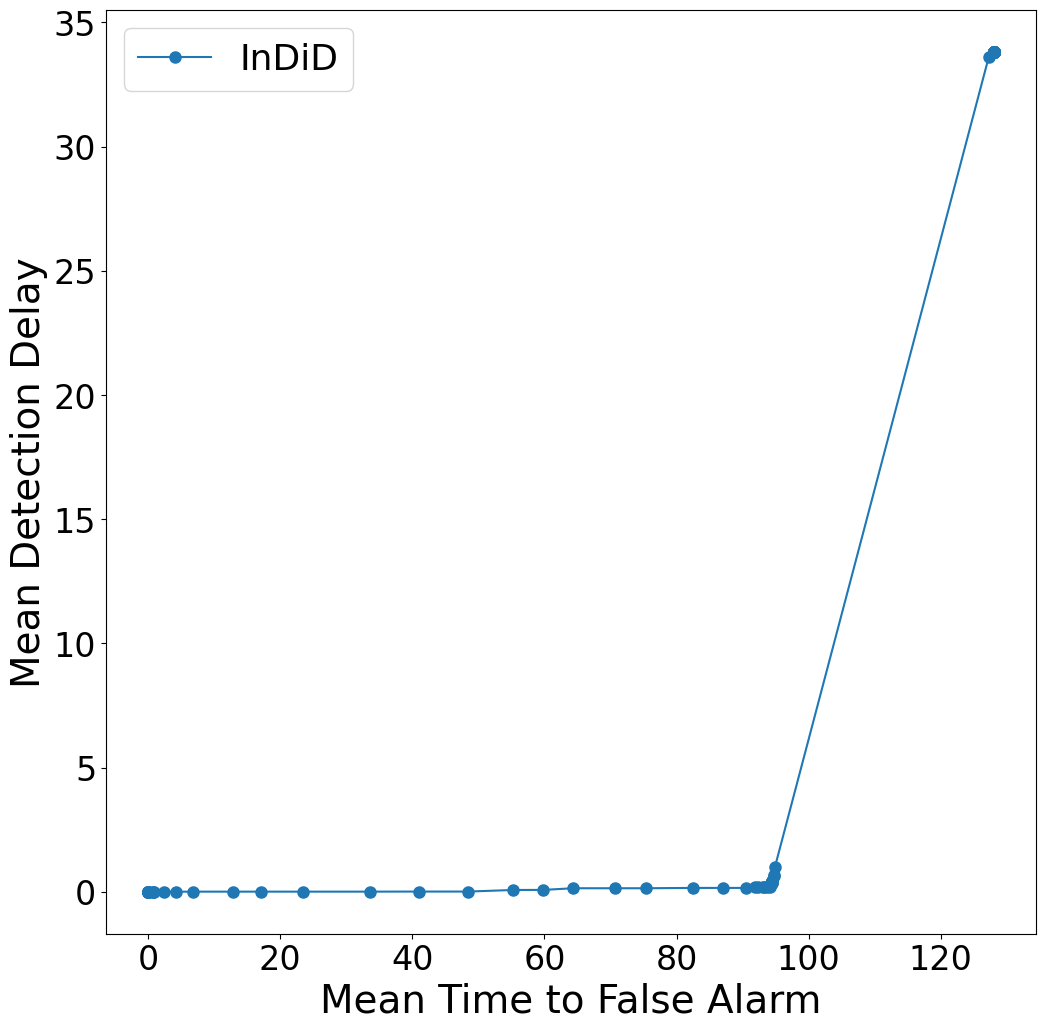

In [19]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list.values(), delay_list.values(), '-o', markersize=8, label="InDiD")
plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26)
plt.show()

## The same experiment with 'BCE' loss

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/synthetic_100D/seq2seq_bce_seed_42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 3.5 K 
1 | loss  | BCELoss | 0     
----------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.

  1%|▊                                                                             | 1/102 [00:01<02:21,  1.40s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



  2%|█▌                                                                            | 2/102 [00:02<02:17,  1.38s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



  3%|██▎                                                                           | 3/102 [00:04<02:16,  1.38s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



  4%|███                                                                           | 4/102 [00:05<02:14,  1.37s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



  5%|███▊                                                                          | 5/102 [00:06<02:01,  1.26s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



  6%|████▌                                                                         | 6/102 [00:07<02:02,  1.27s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



  7%|█████▎                                                                        | 7/102 [00:09<02:01,  1.28s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



  8%|██████                                                                        | 8/102 [00:10<02:02,  1.31s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



  9%|██████▉                                                                       | 9/102 [00:11<02:01,  1.31s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 10%|███████▌                                                                     | 10/102 [00:13<02:00,  1.31s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 11%|████████▎                                                                    | 11/102 [00:14<02:02,  1.35s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 12%|█████████                                                                    | 12/102 [00:15<02:01,  1.35s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 13%|█████████▊                                                                   | 13/102 [00:17<01:58,  1.33s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 14%|██████████▌                                                                  | 14/102 [00:18<01:53,  1.29s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 15%|███████████▎                                                                 | 15/102 [00:19<01:51,  1.28s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 16%|████████████                                                                 | 16/102 [00:20<01:49,  1.28s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 17%|████████████▊                                                                | 17/102 [00:22<01:50,  1.30s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 18%|█████████████▌                                                               | 18/102 [00:23<01:51,  1.32s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 19%|██████████████▎                                                              | 19/102 [00:25<01:50,  1.33s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 20%|███████████████                                                              | 20/102 [00:26<01:50,  1.34s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 21%|███████████████▊                                                             | 21/102 [00:27<01:50,  1.36s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 22%|████████████████▌                                                            | 22/102 [00:29<01:49,  1.37s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 23%|█████████████████▎                                                           | 23/102 [00:30<01:46,  1.34s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 24%|██████████████████                                                           | 24/102 [00:31<01:40,  1.29s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 25%|██████████████████▊                                                          | 25/102 [00:32<01:37,  1.26s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 25%|███████████████████▋                                                         | 26/102 [00:34<01:35,  1.26s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 26%|████████████████████▍                                                        | 27/102 [00:35<01:36,  1.29s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 27%|█████████████████████▏                                                       | 28/102 [00:36<01:38,  1.33s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 28%|█████████████████████▉                                                       | 29/102 [00:38<01:37,  1.34s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 29%|██████████████████████▋                                                      | 30/102 [00:39<01:37,  1.36s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 30%|███████████████████████▍                                                     | 31/102 [00:41<01:36,  1.36s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 31%|████████████████████████▏                                                    | 32/102 [00:42<01:32,  1.32s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 32%|████████████████████████▉                                                    | 33/102 [00:43<01:29,  1.29s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 33%|█████████████████████████▋                                                   | 34/102 [00:44<01:26,  1.27s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 34%|██████████████████████████▍                                                  | 35/102 [00:45<01:24,  1.27s/it]

TN: 1, FP: 298, FN: 0, TP: 1, DELAY:0.0, FP_DELAY:0.5199999809265137, COVER: 0.823731689453125



 35%|███████████████████████████▏                                                 | 36/102 [00:47<01:26,  1.31s/it]

TN: 2, FP: 297, FN: 0, TP: 1, DELAY:0.0, FP_DELAY:0.9466666579246521, COVER: 0.823731689453125



 36%|███████████████████████████▉                                                 | 37/102 [00:48<01:25,  1.32s/it]

TN: 4, FP: 294, FN: 0, TP: 2, DELAY:0.0, FP_DELAY:1.9366666078567505, COVER: 0.8252254263810286



 37%|████████████████████████████▋                                                | 38/102 [00:50<01:24,  1.33s/it]

TN: 8, FP: 287, FN: 0, TP: 5, DELAY:0.0033333334140479565, FP_DELAY:4.246666431427002, COVER: 0.8300598241158169



 38%|█████████████████████████████▍                                               | 39/102 [00:51<01:25,  1.36s/it]

TN: 12, FP: 280, FN: 0, TP: 8, DELAY:0.0033333334140479565, FP_DELAY:6.4066667556762695, COVER: 0.8325961087953199



 39%|██████████████████████████████▏                                              | 40/102 [00:52<01:23,  1.35s/it]

TN: 16, FP: 268, FN: 0, TP: 16, DELAY:0.006666666828095913, FP_DELAY:9.513333320617676, COVER: 0.8398203461465104



 40%|██████████████████████████████▉                                              | 41/102 [00:53<01:18,  1.29s/it]

TN: 31, FP: 248, FN: 0, TP: 21, DELAY:0.006666666828095913, FP_DELAY:17.3266658782959, COVER: 0.8466343109902603



 41%|███████████████████████████████▋                                             | 42/102 [00:55<01:17,  1.29s/it]

TN: 46, FP: 218, FN: 2, TP: 34, DELAY:0.12666666507720947, FP_DELAY:27.633333206176758, COVER: 0.863131138890324



 42%|████████████████████████████████▍                                            | 43/102 [00:56<01:12,  1.23s/it]

TN: 54, FP: 196, FN: 2, TP: 48, DELAY:0.1599999964237213, FP_DELAY:34.23666763305664, COVER: 0.8810468386123269



 43%|█████████████████████████████████▏                                           | 44/102 [00:57<01:10,  1.21s/it]

TN: 65, FP: 162, FN: 3, TP: 70, DELAY:0.27000001072883606, FP_DELAY:43.776668548583984, COVER: 0.9043586192673225



 44%|█████████████████████████████████▉                                           | 45/102 [00:58<01:06,  1.16s/it]

TN: 81, FP: 125, FN: 3, TP: 91, DELAY:0.4033333361148834, FP_DELAY:55.4566650390625, COVER: 0.9245072696975486



 45%|██████████████████████████████████▋                                          | 46/102 [00:59<01:09,  1.24s/it]

TN: 93, FP: 95, FN: 3, TP: 109, DELAY:0.5333333611488342, FP_DELAY:63.94333267211914, COVER: 0.9455140097341587



 46%|███████████████████████████████████▍                                         | 47/102 [01:01<01:10,  1.29s/it]

TN: 111, FP: 64, FN: 3, TP: 122, DELAY:0.6366666555404663, FP_DELAY:74.2699966430664, COVER: 0.9576038761406691



 47%|████████████████████████████████████▏                                        | 48/102 [01:02<01:10,  1.31s/it]

TN: 124, FP: 41, FN: 3, TP: 132, DELAY:0.746666669845581, FP_DELAY:82.12000274658203, COVER: 0.9660016588233012



 48%|████████████████████████████████████▉                                        | 49/102 [01:04<01:09,  1.32s/it]

TN: 132, FP: 25, FN: 4, TP: 139, DELAY:0.8633333444595337, FP_DELAY:87.14666748046875, COVER: 0.9709671995484662



 49%|█████████████████████████████████████▋                                       | 50/102 [01:05<01:10,  1.36s/it]

TN: 135, FP: 16, FN: 4, TP: 145, DELAY:0.9766666889190674, FP_DELAY:89.58333587646484, COVER: 0.9762903760495564



 50%|██████████████████████████████████████▌                                      | 51/102 [01:06<01:09,  1.37s/it]

TN: 140, FP: 5, FN: 4, TP: 151, DELAY:1.0866667032241821, FP_DELAY:92.87999725341797, COVER: 0.9795725452602194



 51%|███████████████████████████████████████▎                                     | 52/102 [01:08<01:06,  1.34s/it]

TN: 142, FP: 0, FN: 4, TP: 154, DELAY:1.2599999904632568, FP_DELAY:94.29666900634766, COVER: 0.9809753600759372



 52%|████████████████████████████████████████                                     | 53/102 [01:09<01:03,  1.29s/it]

TN: 142, FP: 0, FN: 4, TP: 154, DELAY:1.3600000143051147, FP_DELAY:94.29666900634766, COVER: 0.9794879949243489



 53%|████████████████████████████████████████▊                                    | 54/102 [01:10<00:56,  1.17s/it]

TN: 142, FP: 0, FN: 4, TP: 154, DELAY:1.4733333587646484, FP_DELAY:94.29666900634766, COVER: 0.9778304372839047



 54%|█████████████████████████████████████████▌                                   | 55/102 [01:11<00:56,  1.21s/it]

TN: 142, FP: 0, FN: 5, TP: 153, DELAY:1.5733333826065063, FP_DELAY:94.30333709716797, COVER: 0.9763582487458905



 55%|██████████████████████████████████████████▎                                  | 56/102 [01:12<00:57,  1.25s/it]

TN: 142, FP: 0, FN: 5, TP: 153, DELAY:1.6466666460037231, FP_DELAY:94.30333709716797, COVER: 0.975272700999797



 56%|███████████████████████████████████████████                                  | 57/102 [01:14<00:57,  1.28s/it]

TN: 142, FP: 0, FN: 5, TP: 153, DELAY:1.7833333015441895, FP_DELAY:94.30333709716797, COVER: 0.9732903709374199



 57%|███████████████████████████████████████████▊                                 | 58/102 [01:15<00:57,  1.31s/it]

TN: 142, FP: 0, FN: 5, TP: 153, DELAY:1.9733333587646484, FP_DELAY:94.30333709716797, COVER: 0.9705634538153682



 58%|████████████████████████████████████████████▌                                | 59/102 [01:17<00:57,  1.34s/it]

TN: 142, FP: 0, FN: 6, TP: 152, DELAY:2.4033334255218506, FP_DELAY:94.46333312988281, COVER: 0.965140372405081



 59%|█████████████████████████████████████████████▎                               | 60/102 [01:18<00:55,  1.33s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 60%|██████████████████████████████████████████████                               | 61/102 [01:19<00:54,  1.34s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 61%|██████████████████████████████████████████████▊                              | 62/102 [01:21<00:54,  1.35s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 62%|███████████████████████████████████████████████▌                             | 63/102 [01:22<00:50,  1.29s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 63%|████████████████████████████████████████████████▎                            | 64/102 [01:23<00:48,  1.27s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 64%|█████████████████████████████████████████████████                            | 65/102 [01:24<00:48,  1.32s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 65%|█████████████████████████████████████████████████▊                           | 66/102 [01:26<00:47,  1.33s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 66%|██████████████████████████████████████████████████▌                          | 67/102 [01:27<00:45,  1.31s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 67%|███████████████████████████████████████████████████▎                         | 68/102 [01:28<00:44,  1.32s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 68%|████████████████████████████████████████████████████                         | 69/102 [01:30<00:44,  1.36s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 69%|████████████████████████████████████████████████████▊                        | 70/102 [01:31<00:43,  1.35s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 70%|█████████████████████████████████████████████████████▌                       | 71/102 [01:32<00:41,  1.34s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 71%|██████████████████████████████████████████████████████▎                      | 72/102 [01:34<00:39,  1.32s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 72%|███████████████████████████████████████████████████████                      | 73/102 [01:35<00:36,  1.26s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 73%|███████████████████████████████████████████████████████▊                     | 74/102 [01:36<00:35,  1.27s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 74%|████████████████████████████████████████████████████████▌                    | 75/102 [01:38<00:35,  1.30s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 75%|█████████████████████████████████████████████████████████▎                   | 76/102 [01:39<00:34,  1.33s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 75%|██████████████████████████████████████████████████████████▏                  | 77/102 [01:40<00:33,  1.32s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 76%|██████████████████████████████████████████████████████████▉                  | 78/102 [01:42<00:31,  1.32s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 77%|███████████████████████████████████████████████████████████▋                 | 79/102 [01:43<00:30,  1.32s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 78%|████████████████████████████████████████████████████████████▍                | 80/102 [01:44<00:29,  1.32s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 79%|█████████████████████████████████████████████████████████████▏               | 81/102 [01:45<00:26,  1.27s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 80%|█████████████████████████████████████████████████████████████▉               | 82/102 [01:47<00:25,  1.28s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 81%|██████████████████████████████████████████████████████████████▋              | 83/102 [01:48<00:24,  1.30s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 82%|███████████████████████████████████████████████████████████████▍             | 84/102 [01:49<00:24,  1.34s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 83%|████████████████████████████████████████████████████████████████▏            | 85/102 [01:51<00:22,  1.34s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 84%|████████████████████████████████████████████████████████████████▉            | 86/102 [01:52<00:21,  1.34s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 85%|█████████████████████████████████████████████████████████████████▋           | 87/102 [01:54<00:20,  1.36s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 86%|██████████████████████████████████████████████████████████████████▍          | 88/102 [01:55<00:19,  1.39s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 87%|███████████████████████████████████████████████████████████████████▏         | 89/102 [01:56<00:17,  1.36s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 88%|███████████████████████████████████████████████████████████████████▉         | 90/102 [01:58<00:16,  1.36s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 89%|████████████████████████████████████████████████████████████████████▋        | 91/102 [01:59<00:14,  1.34s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 90%|█████████████████████████████████████████████████████████████████████▍       | 92/102 [02:00<00:13,  1.34s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 91%|██████████████████████████████████████████████████████████████████████▏      | 93/102 [02:02<00:12,  1.34s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 92%|██████████████████████████████████████████████████████████████████████▉      | 94/102 [02:03<00:10,  1.36s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 93%|███████████████████████████████████████████████████████████████████████▋     | 95/102 [02:04<00:09,  1.38s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 94%|████████████████████████████████████████████████████████████████████████▍    | 96/102 [02:06<00:07,  1.33s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 95%|█████████████████████████████████████████████████████████████████████████▏   | 97/102 [02:07<00:06,  1.36s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 96%|█████████████████████████████████████████████████████████████████████████▉   | 98/102 [02:08<00:05,  1.31s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 97%|██████████████████████████████████████████████████████████████████████████▋  | 99/102 [02:10<00:03,  1.32s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 98%|██████████████████████████████████████████████████████████████████████████▌ | 100/102 [02:11<00:02,  1.28s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 99%|███████████████████████████████████████████████████████████████████████████▎| 101/102 [02:12<00:01,  1.24s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



100%|████████████████████████████████████████████████████████████████████████████| 102/102 [02:13<00:00,  1.31s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667
AUC: 642.2576
Time to FA 94.2967, delay detection 1.26 for best-F1 threshold: 0.5126
TN 142, FP 0, FN 4, TP 154 for best-F1 threshold: 0.5126
Max F1 0.9872: for best-F1 threshold 0.5126
COVER 0.981: for best-F1 threshold 0.5126
Max COVER 0.981: for threshold 0.5126


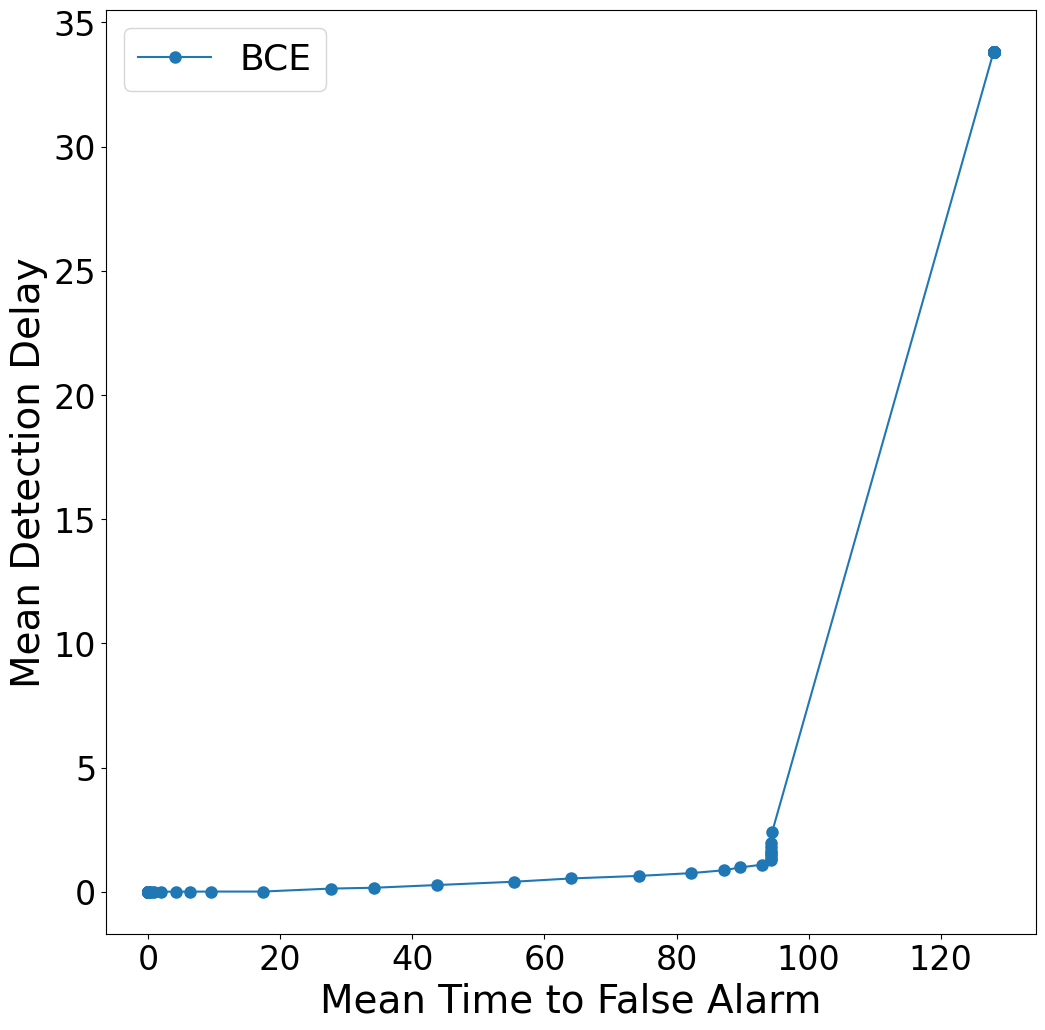

In [21]:
# define core model for an experiment with 'bce' loss
core_model_bce = core_models.BaseRnn(
    input_size=100,
    hidden_dim=8,
    n_layers=1,
    drop_prob=0.5
)

# define CPDModel with 'bce' loss
bce_model = cpd_models.CPDModel(
    loss_type="bce",
    args=args,
    model=core_model_bce,
    train_dataset=train_dataset,
    test_dataset=test_dataset
)

# use logger
model_name = f'seq2seq_bce_seed_{SEED}'
logger = TensorBoardLogger(save_dir=f'logs/{experiments_name}', name=model_name)

# define trainer with custom parameters
trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    benchmark=True,
    check_val_every_n_epoch=1,
    gradient_clip_val=0.,
    logger=logger,
    
    # use early stopping
    callbacks=EarlyStopping(monitor="val_loss", min_delta=0, patience=10)
)

trainer.fit(bce_model)

threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

# evaluate model
metrics_local, delay_list, fp_delay_list = \
    metrics.evaluation_pipeline(bce_model,
                                bce_model.val_dataloader(),
                                threshold_list,
                                device="cpu", # choose 'cpu' or 'cuda' if available
                                model_type="seq2seq",
                                verbose=True
                               )

plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list.values(), delay_list.values(), '-o', markersize=8, label="BCE")
plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26)
plt.show()

## The same experiment with 'Combined' loss

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 3.5 K 
1 | loss  | BCELoss | 0     
----------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
/home/eromanenkova/stash/eromanenkova/miniconda3/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory logs/synthetic_100D/seq2seq_combined_seed_42/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 3.5 K 
1 | loss  | CPDLoss | 0     
----------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.

  1%|▊                                                                             | 1/102 [00:01<02:01,  1.20s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



  2%|█▌                                                                            | 2/102 [00:02<02:00,  1.21s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



  3%|██▎                                                                           | 3/102 [00:03<02:10,  1.32s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



  4%|███                                                                           | 4/102 [00:05<02:10,  1.34s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



  5%|███▊                                                                          | 5/102 [00:06<02:10,  1.35s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



  6%|████▌                                                                         | 6/102 [00:08<02:13,  1.39s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



  7%|█████▎                                                                        | 7/102 [00:09<02:12,  1.39s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



  8%|██████                                                                        | 8/102 [00:10<02:07,  1.36s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



  9%|██████▉                                                                       | 9/102 [00:12<02:04,  1.34s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 10%|███████▌                                                                     | 10/102 [00:13<01:58,  1.28s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 11%|████████▎                                                                    | 11/102 [00:14<01:51,  1.22s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 12%|█████████                                                                    | 12/102 [00:15<01:52,  1.25s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 13%|█████████▊                                                                   | 13/102 [00:17<01:56,  1.31s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 14%|██████████▌                                                                  | 14/102 [00:18<01:56,  1.33s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 15%|███████████▎                                                                 | 15/102 [00:19<01:55,  1.33s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 16%|████████████                                                                 | 16/102 [00:21<01:55,  1.35s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 17%|████████████▊                                                                | 17/102 [00:22<01:57,  1.38s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 18%|█████████████▌                                                               | 18/102 [00:23<01:51,  1.33s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 19%|██████████████▎                                                              | 19/102 [00:25<01:52,  1.36s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 20%|███████████████                                                              | 20/102 [00:26<01:46,  1.30s/it]

TN: 0, FP: 299, FN: 0, TP: 1, DELAY:0.0, FP_DELAY:0.1899999976158142, COVER: 0.8242948404947916



 21%|███████████████▊                                                             | 21/102 [00:27<01:44,  1.29s/it]

TN: 0, FP: 298, FN: 0, TP: 2, DELAY:0.0, FP_DELAY:0.40666666626930237, COVER: 0.8259611002604167



 22%|████████████████▌                                                            | 22/102 [00:29<01:45,  1.32s/it]

TN: 2, FP: 294, FN: 0, TP: 4, DELAY:0.0, FP_DELAY:1.7699999809265137, COVER: 0.8274076334635416



 23%|█████████████████▎                                                           | 23/102 [00:30<01:46,  1.34s/it]

TN: 4, FP: 285, FN: 1, TP: 10, DELAY:0.019999999552965164, FP_DELAY:4.236666679382324, COVER: 0.8351900227864584



 24%|██████████████████                                                           | 24/102 [00:31<01:45,  1.35s/it]

TN: 14, FP: 270, FN: 1, TP: 15, DELAY:0.019999999552965164, FP_DELAY:10.053333282470703, COVER: 0.8387215169270833



 25%|██████████████████▊                                                          | 25/102 [00:33<01:47,  1.39s/it]

TN: 22, FP: 253, FN: 1, TP: 24, DELAY:0.023333333432674408, FP_DELAY:15.383333206176758, COVER: 0.8466480848524305



 25%|███████████████████▋                                                         | 26/102 [00:34<01:47,  1.42s/it]

TN: 32, FP: 233, FN: 1, TP: 34, DELAY:0.023333333432674408, FP_DELAY:21.549999237060547, COVER: 0.8592327202690971



 26%|████████████████████▍                                                        | 27/102 [00:35<01:41,  1.36s/it]

TN: 48, FP: 205, FN: 2, TP: 45, DELAY:0.07999999821186066, FP_DELAY:30.866666793823242, COVER: 0.8747010633680554



 27%|█████████████████████▏                                                       | 28/102 [00:37<01:37,  1.32s/it]

TN: 58, FP: 183, FN: 2, TP: 57, DELAY:0.1366666704416275, FP_DELAY:37.46666717529297, COVER: 0.8903556371035583



 28%|█████████████████████▉                                                       | 29/102 [00:38<01:35,  1.30s/it]

TN: 70, FP: 147, FN: 3, TP: 80, DELAY:0.23999999463558197, FP_DELAY:47.34333419799805, COVER: 0.9156414116753471



 29%|██████████████████████▋                                                      | 30/102 [00:39<01:35,  1.33s/it]

TN: 85, FP: 116, FN: 3, TP: 96, DELAY:0.25, FP_DELAY:57.51333236694336, COVER: 0.9343600461495968



 30%|███████████████████████▍                                                     | 31/102 [00:41<01:35,  1.35s/it]

TN: 100, FP: 80, FN: 3, TP: 117, DELAY:0.34333333373069763, FP_DELAY:68.73999786376953, COVER: 0.9527351848194496



 31%|████████████████████████▏                                                    | 32/102 [00:42<01:35,  1.37s/it]

TN: 114, FP: 55, FN: 3, TP: 128, DELAY:0.36666667461395264, FP_DELAY:77.18000030517578, COVER: 0.9664369086276137



 32%|████████████████████████▉                                                    | 33/102 [00:44<01:34,  1.37s/it]

TN: 122, FP: 39, FN: 3, TP: 136, DELAY:0.43666666746139526, FP_DELAY:81.7933349609375, COVER: 0.9749665940808259



 33%|█████████████████████████▋                                                   | 34/102 [00:45<01:34,  1.39s/it]

TN: 130, FP: 24, FN: 4, TP: 142, DELAY:0.5366666913032532, FP_DELAY:86.7300033569336, COVER: 0.9790553528128726



 34%|██████████████████████████▍                                                  | 35/102 [00:46<01:31,  1.36s/it]

TN: 136, FP: 14, FN: 5, TP: 145, DELAY:0.5699999928474426, FP_DELAY:90.68000030517578, COVER: 0.9827756490368309



 35%|███████████████████████████▏                                                 | 36/102 [00:48<01:28,  1.34s/it]

TN: 140, FP: 5, FN: 5, TP: 150, DELAY:0.6133333444595337, FP_DELAY:93.1866683959961, COVER: 0.9892870216343829



 36%|███████████████████████████▉                                                 | 37/102 [00:49<01:25,  1.32s/it]

TN: 141, FP: 4, FN: 5, TP: 150, DELAY:0.6299999952316284, FP_DELAY:93.61333465576172, COVER: 0.9890398454791756



 37%|████████████████████████████▋                                                | 38/102 [00:50<01:24,  1.32s/it]

TN: 141, FP: 1, FN: 7, TP: 151, DELAY:0.7933333516120911, FP_DELAY:94.4800033569336, COVER: 0.9918692215891785



 38%|█████████████████████████████▍                                               | 39/102 [00:52<01:23,  1.33s/it]

TN: 141, FP: 1, FN: 7, TP: 151, DELAY:0.8166666626930237, FP_DELAY:94.4800033569336, COVER: 0.9915103191005975



 39%|██████████████████████████████▏                                              | 40/102 [00:53<01:24,  1.36s/it]

TN: 141, FP: 1, FN: 7, TP: 151, DELAY:0.8866666555404663, FP_DELAY:94.4800033569336, COVER: 0.990600354460743



 40%|██████████████████████████████▉                                              | 41/102 [00:54<01:23,  1.37s/it]

TN: 142, FP: 0, FN: 7, TP: 151, DELAY:0.9933333396911621, FP_DELAY:94.90666961669922, COVER: 0.9891064608118991



 41%|███████████████████████████████▋                                             | 42/102 [00:56<01:23,  1.39s/it]

TN: 142, FP: 0, FN: 9, TP: 149, DELAY:1.1033333539962769, FP_DELAY:94.94000244140625, COVER: 0.9879241673523541



 42%|████████████████████████████████▍                                            | 43/102 [00:57<01:23,  1.42s/it]

TN: 142, FP: 0, FN: 13, TP: 145, DELAY:1.9833333492279053, FP_DELAY:95.90666961669922, COVER: 0.9835885287002759



 43%|█████████████████████████████████▏                                           | 44/102 [00:59<01:20,  1.39s/it]

TN: 142, FP: 0, FN: 14, TP: 144, DELAY:2.8333332538604736, FP_DELAY:96.19000244140625, COVER: 0.9778870751441002



 44%|█████████████████████████████████▉                                           | 45/102 [01:00<01:17,  1.36s/it]

TN: 142, FP: 0, FN: 22, TP: 136, DELAY:4.276666641235352, FP_DELAY:98.163330078125, COVER: 0.9720220826565281



 45%|██████████████████████████████████▋                                          | 46/102 [01:01<01:14,  1.32s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 46%|███████████████████████████████████▍                                         | 47/102 [01:03<01:14,  1.35s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 47%|████████████████████████████████████▏                                        | 48/102 [01:04<01:11,  1.32s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 48%|████████████████████████████████████▉                                        | 49/102 [01:05<01:11,  1.34s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 49%|█████████████████████████████████████▋                                       | 50/102 [01:07<01:10,  1.36s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 50%|██████████████████████████████████████▌                                      | 51/102 [01:08<01:11,  1.40s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 51%|███████████████████████████████████████▎                                     | 52/102 [01:09<01:09,  1.40s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 52%|████████████████████████████████████████                                     | 53/102 [01:11<01:07,  1.38s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 53%|████████████████████████████████████████▊                                    | 54/102 [01:12<01:03,  1.32s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 54%|█████████████████████████████████████████▌                                   | 55/102 [01:13<01:01,  1.30s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 55%|██████████████████████████████████████████▎                                  | 56/102 [01:15<01:00,  1.33s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 56%|███████████████████████████████████████████                                  | 57/102 [01:16<00:58,  1.31s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 57%|███████████████████████████████████████████▊                                 | 58/102 [01:17<00:58,  1.32s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 58%|████████████████████████████████████████████▌                                | 59/102 [01:19<00:57,  1.34s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 59%|█████████████████████████████████████████████▎                               | 60/102 [01:20<00:57,  1.36s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 60%|██████████████████████████████████████████████                               | 61/102 [01:21<00:55,  1.35s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 61%|██████████████████████████████████████████████▊                              | 62/102 [01:23<00:54,  1.37s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 62%|███████████████████████████████████████████████▌                             | 63/102 [01:24<00:53,  1.37s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 63%|████████████████████████████████████████████████▎                            | 64/102 [01:25<00:50,  1.33s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 64%|█████████████████████████████████████████████████                            | 65/102 [01:27<00:49,  1.35s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 65%|█████████████████████████████████████████████████▊                           | 66/102 [01:28<00:47,  1.32s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 66%|██████████████████████████████████████████████████▌                          | 67/102 [01:29<00:46,  1.34s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 67%|███████████████████████████████████████████████████▎                         | 68/102 [01:31<00:46,  1.37s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 68%|████████████████████████████████████████████████████                         | 69/102 [01:32<00:45,  1.39s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 69%|████████████████████████████████████████████████████▊                        | 70/102 [01:34<00:44,  1.40s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 70%|█████████████████████████████████████████████████████▌                       | 71/102 [01:35<00:43,  1.39s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 71%|██████████████████████████████████████████████████████▎                      | 72/102 [01:36<00:41,  1.37s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 72%|███████████████████████████████████████████████████████                      | 73/102 [01:38<00:39,  1.38s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 73%|███████████████████████████████████████████████████████▊                     | 74/102 [01:39<00:37,  1.35s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 74%|████████████████████████████████████████████████████████▌                    | 75/102 [01:40<00:34,  1.26s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 75%|█████████████████████████████████████████████████████████▎                   | 76/102 [01:41<00:33,  1.29s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 75%|██████████████████████████████████████████████████████████▏                  | 77/102 [01:43<00:32,  1.30s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 76%|██████████████████████████████████████████████████████████▉                  | 78/102 [01:44<00:31,  1.31s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 77%|███████████████████████████████████████████████████████████▋                 | 79/102 [01:46<00:30,  1.33s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 78%|████████████████████████████████████████████████████████████▍                | 80/102 [01:47<00:29,  1.34s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 79%|█████████████████████████████████████████████████████████████▏               | 81/102 [01:48<00:28,  1.34s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 80%|█████████████████████████████████████████████████████████████▉               | 82/102 [01:49<00:25,  1.27s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 81%|██████████████████████████████████████████████████████████████▋              | 83/102 [01:51<00:24,  1.30s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 82%|███████████████████████████████████████████████████████████████▍             | 84/102 [01:52<00:22,  1.26s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 83%|████████████████████████████████████████████████████████████████▏            | 85/102 [01:53<00:22,  1.31s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 84%|████████████████████████████████████████████████████████████████▉            | 86/102 [01:55<00:21,  1.33s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 85%|█████████████████████████████████████████████████████████████████▋           | 87/102 [01:56<00:19,  1.32s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 86%|██████████████████████████████████████████████████████████████████▍          | 88/102 [01:57<00:19,  1.37s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 87%|███████████████████████████████████████████████████████████████████▏         | 89/102 [01:59<00:18,  1.41s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 88%|███████████████████████████████████████████████████████████████████▉         | 90/102 [02:00<00:16,  1.37s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 89%|████████████████████████████████████████████████████████████████████▋        | 91/102 [02:01<00:14,  1.34s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 90%|█████████████████████████████████████████████████████████████████████▍       | 92/102 [02:03<00:13,  1.30s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 91%|██████████████████████████████████████████████████████████████████████▏      | 93/102 [02:04<00:11,  1.26s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 92%|██████████████████████████████████████████████████████████████████████▉      | 94/102 [02:05<00:10,  1.31s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 93%|███████████████████████████████████████████████████████████████████████▋     | 95/102 [02:07<00:09,  1.34s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 94%|████████████████████████████████████████████████████████████████████████▍    | 96/102 [02:08<00:07,  1.33s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 95%|█████████████████████████████████████████████████████████████████████████▏   | 97/102 [02:09<00:06,  1.35s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 96%|█████████████████████████████████████████████████████████████████████████▉   | 98/102 [02:11<00:05,  1.38s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 97%|██████████████████████████████████████████████████████████████████████████▋  | 99/102 [02:12<00:03,  1.31s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 98%|██████████████████████████████████████████████████████████████████████████▌ | 100/102 [02:13<00:02,  1.29s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 99%|███████████████████████████████████████████████████████████████████████████▎| 101/102 [02:15<00:01,  1.28s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



100%|████████████████████████████████████████████████████████████████████████████| 102/102 [02:16<00:00,  1.34s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667
AUC: 599.0459
Time to FA 94.9067, delay detection 0.9933 for best-F1 threshold: 0.2572
TN 142, FP 0, FN 7, TP 151 for best-F1 threshold: 0.2572
Max F1 0.9773: for best-F1 threshold 0.2572
COVER 0.9891: for best-F1 threshold 0.2572
Max COVER 0.9919: for threshold 0.2036


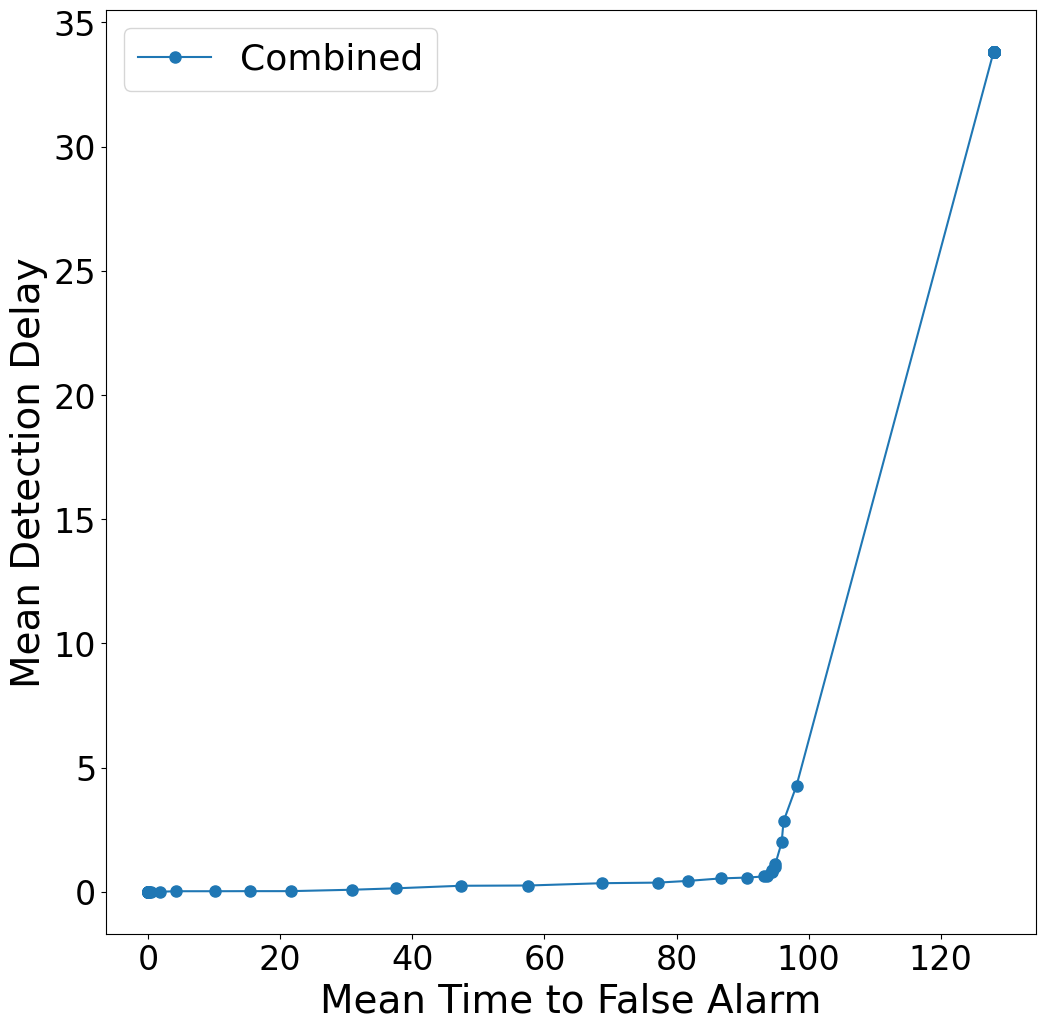

In [23]:
# define core model for an experiment with 'combined' loss
core_model_combined = core_models.BaseRnn(
    input_size=100,
    hidden_dim=8,
    n_layers=1,
    drop_prob=0.5
)

# define 2 CPDModels for this experiment
# note that they share the one and the same core model 
combined_model_1 = cpd_models.CPDModel(
    loss_type="bce",
    args=args,
    model=core_model_combined,
    train_dataset=train_dataset,
    test_dataset=test_dataset
)

combined_model_2 = cpd_models.CPDModel(
    loss_type="indid",
    args=args,
    model=core_model_combined,
    train_dataset=train_dataset,
    test_dataset=test_dataset
)

# use logger
model_name = f'seq2seq_combined_seed_{SEED}'
logger = TensorBoardLogger(save_dir=f'logs/{experiments_name}', name=model_name)

# define trainer with custom parameters
trainer_1 = pl.Trainer(
    max_epochs=15,
    gpus=1,
    benchmark=True,
    check_val_every_n_epoch=1,
    gradient_clip_val=0.,
    logger=logger,
    
    # use early stopping
    callbacks=EarlyStopping(monitor="val_loss", min_delta=0, patience=10)
)

trainer_2 = pl.Trainer(
    max_epochs=15,
    gpus=1,
    benchmark=True,
    check_val_every_n_epoch=1,
    gradient_clip_val=0.,
    logger=logger,
    
    # use early stopping
    callbacks=EarlyStopping(monitor="val_loss", min_delta=0, patience=10)
)

trainer_1.fit(combined_model_1)
trainer_2.fit(combined_model_2)

threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

# evaluate model
metrics_local, delay_list, fp_delay_list = \
    metrics.evaluation_pipeline(combined_model_2, # use the second model for evaluation
                                combined_model_2.val_dataloader(),
                                threshold_list,
                                device="cpu", # choose 'cpu' or 'cuda' if available
                                model_type="seq2seq",
                                verbose=True
                               )
# plot detection curve
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list.values(), delay_list.values(), '-o', markersize=8, label="Combined")
plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26)
plt.show()

## Experiments with KL-CPD baseline

In [29]:
# create dictionary with default arguments for consistency with our interface
# define arguments as they are set in the corresponding config file
model = dict()
model["input_dim"] = 100
model["rnn_hid_dim"] = 16
model["num_layers"] = 1
model["wnd_dim"] = 8
model["window_1"] = 8
model["window_2"] = 8


learning = dict()
learning["batch_size"] = 64
learning["lr"] = 0.001
learning["grad_clip"] = 0.0
learning["critic_iters"] = 5
learning["weight_decay"] = 0.
learning["grad_clip"] = 10.
learning["weight_clip"] = 0.1

loss = dict()
loss["lambda_real"] = 10
loss["lambda_ae"] = 0.1
loss["sqdist"] = 3

args = dict()
args["model"] = model
args["learning"] = learning
args["loss"] = loss

args["experiments_name"] = experiments_name
args["num_workers"] = 2

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type | Params
-------------------------------------------
0 | net_generator     | NetG | 13.0 K
1 | net_discriminator | NetD | 41.1 K
-------------------------------------------
54.1 K    Trainable params
0         Non-trainable params
54.1 K    Total params
0.216     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


  4%|██▉                                                                            | 1/27 [00:21<09:09, 21.13s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



  7%|█████▊                                                                         | 2/27 [00:43<09:01, 21.66s/it]

TN: 0, FP: 282, FN: 0, TP: 18, DELAY:0.3766666650772095, FP_DELAY:14.623332977294922, COVER: 0.76841348155574



 11%|████████▊                                                                      | 3/27 [01:05<08:45, 21.90s/it]

TN: 0, FP: 282, FN: 0, TP: 18, DELAY:0.3766666650772095, FP_DELAY:14.623332977294922, COVER: 0.76841348155574



 15%|███████████▋                                                                   | 4/27 [01:26<08:17, 21.63s/it]

TN: 0, FP: 282, FN: 0, TP: 18, DELAY:0.3766666650772095, FP_DELAY:14.623332977294922, COVER: 0.76841348155574



 19%|██████████████▋                                                                | 5/27 [01:48<07:59, 21.78s/it]

TN: 0, FP: 282, FN: 0, TP: 18, DELAY:0.3766666650772095, FP_DELAY:14.623332977294922, COVER: 0.76841348155574



 22%|█████████████████▌                                                             | 6/27 [02:10<07:39, 21.87s/it]

TN: 0, FP: 282, FN: 0, TP: 18, DELAY:0.3766666650772095, FP_DELAY:14.623332977294922, COVER: 0.76841348155574



 26%|████████████████████▍                                                          | 7/27 [02:32<07:18, 21.93s/it]

TN: 0, FP: 282, FN: 0, TP: 18, DELAY:0.3766666650772095, FP_DELAY:14.623332977294922, COVER: 0.76841348155574



 30%|███████████████████████▍                                                       | 8/27 [02:54<06:57, 21.97s/it]

TN: 0, FP: 282, FN: 0, TP: 18, DELAY:0.3766666650772095, FP_DELAY:14.630000114440918, COVER: 0.7685102242074466



 33%|██████████████████████████▎                                                    | 9/27 [03:16<06:34, 21.89s/it]

TN: 0, FP: 282, FN: 0, TP: 18, DELAY:0.3766666650772095, FP_DELAY:14.636666297912598, COVER: 0.76846420889521



 37%|████████████████████████████▉                                                 | 10/27 [03:38<06:12, 21.89s/it]

TN: 0, FP: 282, FN: 1, TP: 17, DELAY:0.7566666603088379, FP_DELAY:15.08666706085205, COVER: 0.7686541655007556



 41%|███████████████████████████████▊                                              | 11/27 [03:59<05:48, 21.79s/it]

TN: 0, FP: 281, FN: 1, TP: 18, DELAY:0.7566666603088379, FP_DELAY:15.146666526794434, COVER: 0.7686080579439911



 44%|██████████████████████████████████▋                                           | 12/27 [04:21<05:25, 21.72s/it]

TN: 0, FP: 281, FN: 1, TP: 18, DELAY:0.7633333206176758, FP_DELAY:15.266666412353516, COVER: 0.7681834127840258



 48%|█████████████████████████████████████▌                                        | 13/27 [04:43<05:05, 21.79s/it]

TN: 0, FP: 281, FN: 2, TP: 17, DELAY:1.1399999856948853, FP_DELAY:15.966666221618652, COVER: 0.7677570641853722



 52%|████████████████████████████████████████▍                                     | 14/27 [05:04<04:41, 21.66s/it]

TN: 0, FP: 281, FN: 2, TP: 17, DELAY:1.1433333158493042, FP_DELAY:16.30666732788086, COVER: 0.7668928762708356



 56%|███████████████████████████████████████████▎                                  | 15/27 [05:26<04:21, 21.76s/it]

TN: 0, FP: 280, FN: 3, TP: 17, DELAY:1.5666667222976685, FP_DELAY:17.34000015258789, COVER: 0.7647045993323999



 59%|██████████████████████████████████████████████▏                               | 16/27 [05:48<03:59, 21.81s/it]

TN: 0, FP: 278, FN: 3, TP: 19, DELAY:1.5833333730697632, FP_DELAY:17.953332901000977, COVER: 0.7637855338503741



 63%|█████████████████████████████████████████████████                             | 17/27 [06:10<03:38, 21.88s/it]

TN: 0, FP: 273, FN: 3, TP: 24, DELAY:1.6633332967758179, FP_DELAY:18.889999389648438, COVER: 0.7618704173219064



 67%|████████████████████████████████████████████████████                          | 18/27 [06:32<03:15, 21.75s/it]

TN: 0, FP: 273, FN: 3, TP: 24, DELAY:1.746666669845581, FP_DELAY:20.030000686645508, COVER: 0.7579507027801753



 70%|██████████████████████████████████████████████████████▉                       | 19/27 [06:53<02:53, 21.74s/it]

TN: 0, FP: 273, FN: 4, TP: 23, DELAY:2.1500000953674316, FP_DELAY:21.816667556762695, COVER: 0.753597463705728



 74%|█████████████████████████████████████████████████████████▊                    | 20/27 [07:15<02:32, 21.84s/it]

TN: 0, FP: 269, FN: 4, TP: 27, DELAY:2.259999990463257, FP_DELAY:23.763334274291992, COVER: 0.7487095574836441



 78%|████████████████████████████████████████████████████████████▋                 | 21/27 [07:37<02:11, 21.85s/it]

TN: 0, FP: 265, FN: 6, TP: 29, DELAY:2.9166667461395264, FP_DELAY:26.226667404174805, COVER: 0.7417311355457743



 81%|███████████████████████████████████████████████████████████████▌              | 22/27 [07:59<01:48, 21.75s/it]

TN: 0, FP: 264, FN: 7, TP: 29, DELAY:3.2766666412353516, FP_DELAY:30.3799991607666, COVER: 0.7380579530905552



 85%|██████████████████████████████████████████████████████████████████▍           | 23/27 [08:20<01:26, 21.55s/it]

TN: 0, FP: 256, FN: 15, TP: 29, DELAY:5.643333435058594, FP_DELAY:35.400001525878906, COVER: 0.7343173534858896



 89%|█████████████████████████████████████████████████████████████████████▎        | 24/27 [08:42<01:05, 21.71s/it]

TN: 2, FP: 252, FN: 19, TP: 27, DELAY:6.7166666984558105, FP_DELAY:40.34000015258789, COVER: 0.7316091917943143



 93%|████████████████████████████████████████████████████████████████████████▏     | 25/27 [09:04<00:43, 21.80s/it]

TN: 5, FP: 242, FN: 28, TP: 25, DELAY:9.306666374206543, FP_DELAY:46.81999969482422, COVER: 0.7316535584744785



 96%|███████████████████████████████████████████████████████████████████████████   | 26/27 [09:26<00:21, 21.71s/it]

TN: 10, FP: 231, FN: 35, TP: 24, DELAY:11.079999923706055, FP_DELAY:52.40999984741211, COVER: 0.7319535860371597



100%|██████████████████████████████████████████████████████████████████████████████| 27/27 [09:48<00:00, 21.78s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667
AUC: 1895.8565
Time to FA 26.2267, delay detection 2.9167 for best-F1 threshold: 0.9487
TN 0, FP 265, FN 6, TP 29 for best-F1 threshold: 0.9487
Max F1 0.1763: for best-F1 threshold 0.9487
COVER 0.7417: for best-F1 threshold 0.9487
Max COVER 0.8226: for threshold -0.001


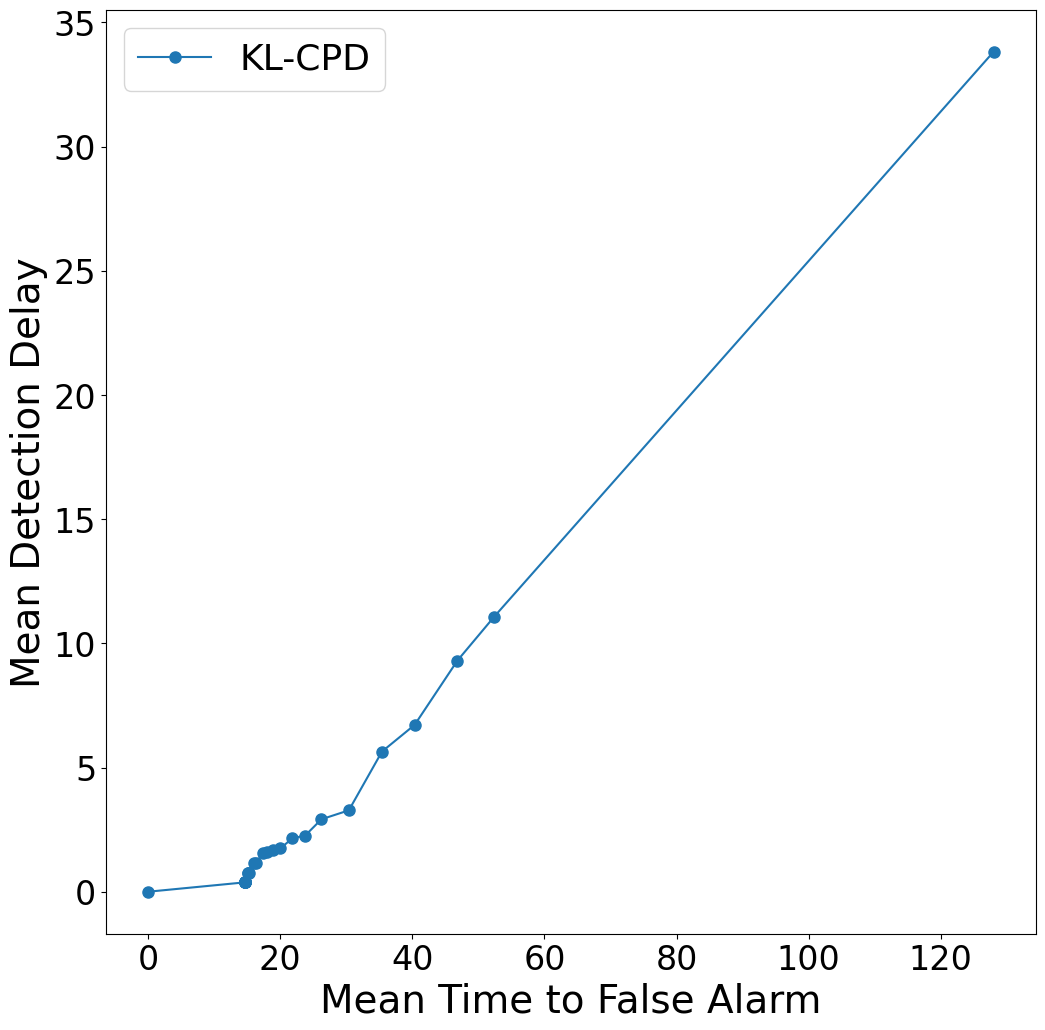

In [31]:
# define core models (discriminator and generator) for KL-CPD model
net_discriminator = klcpd.NetD(args=args)
net_generator = klcpd.NetG(args=args)

# create KL-CPD model (our pytorch_lightning wrapper)
klcpd_model = klcpd.KLCPD(
    args=args,
    net_discriminator=net_discriminator,
    net_generator=net_generator,
    train_dataset=train_dataset,
    test_dataset=test_dataset
)

# use logger
model_name = f'kl_cpd_seed_{SEED}'
logger = TensorBoardLogger(save_dir=f'logs/{experiments_name}', name=model_name)

# define trainer with custom parameters
trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    benchmark=True,
    check_val_every_n_epoch=1,
    gradient_clip_val=0.,
    logger=logger,
    
    # use early stopping
    callbacks=EarlyStopping(monitor="val_mmd2_real_D", min_delta=0.00001, patience=5)
)

trainer.fit(klcpd_model)

threshold_number = 25
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

# evaluate model
metrics_local, delay_list, fp_delay_list = \
    metrics.evaluation_pipeline(klcpd_model, # use the second model for evaluation
                                klcpd_model.val_dataloader(),
                                threshold_list,
                                device="cuda", # choose 'cpu' or 'cuda' if available
                                model_type="kl_cpd",
                                scale=100,
                                verbose=True
                               )

# plot detection curve
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list.values(), delay_list.values(), '-o', markersize=8, label="KL-CPD")
plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26)
plt.show()

## Experiments with TS-CP2 baseline

In [37]:
# create dictionary with default arguments for consistency with our interface
# define arguments as they are set in the corresponding config file
model = dict()
model["c_in"] = 100
model["nb_filters"] = 4
model["nb_stacks"] = 2
model["kernel_size"] = 5
model["dilations"] = [1, 2, 4, 8]
model["use_skip_connections"] = True
model["use_batch_norm"] = False
model["use_layer_norm"] = False
model["use_weight_norm"] = False
model["dropout_rate"] = 0.
model["seq_len"] = 16
model["n_steps"] = 4
model["code_size"] = 4
model["window"] = 16
model["window_1"] = 16
model["window_2"] = 16


learning = dict()
learning["batch_size"] = 4
learning["lr"] = 0.0001
learning["grad_clip"] = 0.0
learning["decay_steps"] = 1000

loss = dict()
loss["temperature"] = 0.5

args = dict()
args["model"] = model
args["learning"] = learning
args["loss"] = loss

args["experiments_name"] = experiments_name
args["num_workers"] = 2

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/synthetic_100D/tscp_seed_42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type            | Params
------------------------------------------
0 | model | BaseTSCPEncoder | 4.5 K 
------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.

  4%|██▉                                                                            | 1/27 [01:00<26:14, 60.56s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



  7%|█████▊                                                                         | 2/27 [01:59<24:44, 59.37s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 11%|████████▊                                                                      | 3/27 [03:00<24:02, 60.10s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 15%|███████████▋                                                                   | 4/27 [03:59<22:54, 59.75s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 19%|██████████████▋                                                                | 5/27 [05:00<22:02, 60.10s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 22%|█████████████████▌                                                             | 6/27 [06:01<21:12, 60.60s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 26%|████████████████████▍                                                          | 7/27 [07:00<20:01, 60.07s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 30%|███████████████████████▍                                                       | 8/27 [08:02<19:11, 60.60s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 33%|██████████████████████████▎                                                    | 9/27 [09:03<18:15, 60.87s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 37%|████████████████████████████▉                                                 | 10/27 [10:04<17:15, 60.89s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 41%|███████████████████████████████▊                                              | 11/27 [11:05<16:12, 60.79s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667



 44%|██████████████████████████████████▋                                           | 12/27 [12:03<14:58, 59.91s/it]

TN: 0, FP: 261, FN: 18, TP: 21, DELAY:7.599999904632568, FP_DELAY:36.66999816894531, COVER: 0.7195803136661221



 48%|█████████████████████████████████████▌                                        | 13/27 [13:02<13:55, 59.67s/it]

TN: 0, FP: 258, FN: 19, TP: 23, DELAY:7.929999828338623, FP_DELAY:37.43000030517578, COVER: 0.7181332905024344



 52%|████████████████████████████████████████▍                                     | 14/27 [14:03<13:03, 60.25s/it]

TN: 0, FP: 258, FN: 19, TP: 23, DELAY:7.9633331298828125, FP_DELAY:37.849998474121094, COVER: 0.715896629704182



 56%|███████████████████████████████████████████▎                                  | 15/27 [15:05<12:06, 60.54s/it]

TN: 0, FP: 256, FN: 20, TP: 24, DELAY:8.356666564941406, FP_DELAY:38.86666488647461, COVER: 0.7127531593675542



 59%|██████████████████████████████████████████████▏                               | 16/27 [16:05<11:06, 60.61s/it]

TN: 0, FP: 253, FN: 28, TP: 19, DELAY:11.083333015441895, FP_DELAY:44.72666549682617, COVER: 0.6978596986251635



 63%|█████████████████████████████████████████████████                             | 17/27 [17:07<10:08, 60.83s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 67%|████████████████████████████████████████████████████                          | 18/27 [18:08<09:07, 60.87s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 70%|██████████████████████████████████████████████████████▉                       | 19/27 [19:07<08:02, 60.28s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 74%|█████████████████████████████████████████████████████████▊                    | 20/27 [20:04<06:56, 59.54s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 78%|████████████████████████████████████████████████████████████▋                 | 21/27 [21:06<06:01, 60.26s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 81%|███████████████████████████████████████████████████████████████▌              | 22/27 [22:08<05:03, 60.69s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 85%|██████████████████████████████████████████████████████████████████▍           | 23/27 [23:07<04:01, 60.26s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 89%|█████████████████████████████████████████████████████████████████████▎        | 24/27 [24:07<03:00, 60.12s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 93%|████████████████████████████████████████████████████████████████████████▏     | 25/27 [25:07<02:00, 60.02s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



 96%|███████████████████████████████████████████████████████████████████████████   | 26/27 [26:06<00:59, 59.79s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667



100%|██████████████████████████████████████████████████████████████████████████████| 27/27 [27:06<00:00, 60.24s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667
AUC: 2083.4653
Time to FA 38.8667, delay detection 8.3567 for best-F1 threshold: 0.6027
TN 0, FP 256, FN 20, TP 24 for best-F1 threshold: 0.6027
Max F1 0.1481: for best-F1 threshold 0.6027
COVER 0.7128: for best-F1 threshold 0.6027
Max COVER 0.8226: for threshold -0.001


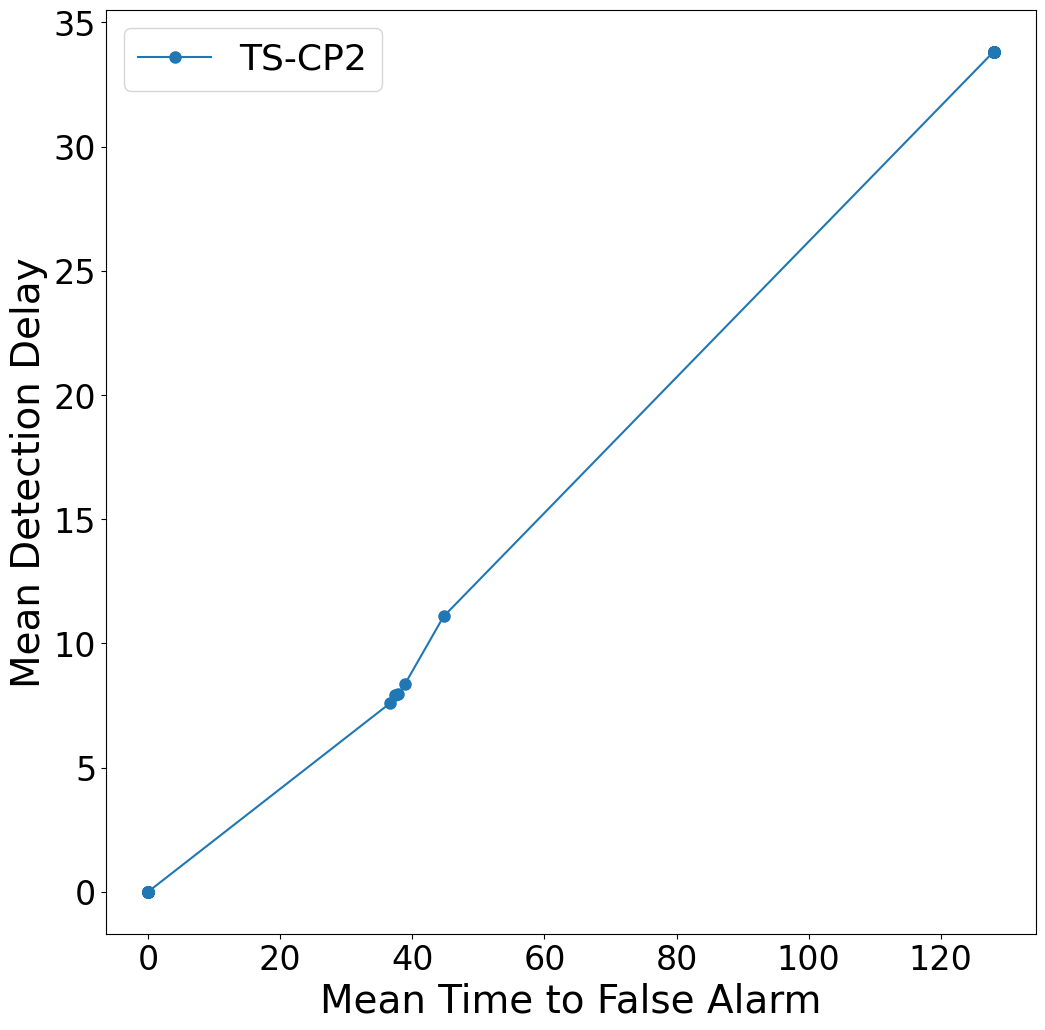

In [41]:
# define encoder for TS-CP2 model
har_encoder = tscp.BaseTSCPEncoder(args=args)

# create KL-CPD model (our pytorch_lightning wrapper)
tscp_model = tscp.TSCP_model(
    args=args,
    model=har_encoder,
    train_dataset=train_dataset,
    test_dataset=test_dataset
)

# use logger
model_name = f'tscp_seed_{SEED}'
logger = TensorBoardLogger(save_dir=f'logs/{experiments_name}', name=model_name)

# define trainer with custom parameters
trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    benchmark=True,
    check_val_every_n_epoch=1,
    gradient_clip_val=0.,
    logger=logger,
    
    # use early stopping
    callbacks=EarlyStopping(monitor="train_loss_epoch", min_delta=0.00001, patience=5)
)

trainer.fit(tscp_model)

# evaluate model
metrics_local, delay_list, fp_delay_list = \
    metrics.evaluation_pipeline(tscp_model, # use the second model for evaluation
                                tscp_model.val_dataloader(),
                                threshold_list,
                                device="cuda", # choose 'cpu' or 'cuda' if available
                                model_type="tscp",
                                scale=1,
                                verbose=True
                               )

# plot detection curve
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list.values(), delay_list.values(), '-o', markersize=8, label="TS-CP2")
plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26)
plt.show()